### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import re
from scipy import stats

### Create a dictionary of dataframes
As there are many csv files, a dictionary will help me easily manage them

In [2]:
df_dict = dict()
for loc in os.listdir('../input/supermind'):
    df_dict[loc.split('.')[0]] = pd.read_csv(f'../input/supermind/{loc}')

In [3]:
##Function for removing stopwords and special characters

from nltk.corpus import stopwords

cachedStopWords = stopwords.words("english")

def removeStopWords(text):
    return ' '.join([word for word in text.split() if word not in cachedStopWords])

def clean(s):

    temp = s.lower()
    temp = re.sub("'", "", temp)
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = temp.split()
    temp = " ".join(word for word in temp)
    return temp

In [4]:
##Convert the sentence column from all dataframes to String type
for key in df_dict.keys():
    if key not in ['term_abb','term_def']:
        df_dict[key].sentence = df_dict[key].sentence.astype(str)

In [5]:
##Counting most common 20 words in each dataset
from collections import Counter
cnt_dict = dict()

for key in df_dict.keys():
    if key not in ['term_abb','term_def']:
        cnt = Counter()
        for txt in df_dict[key].sentence:
            for text in removeStopWords(txt.lower()).split():
                cnt[text] += 1
        cnt_dict[key] = cnt.most_common(20)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-package

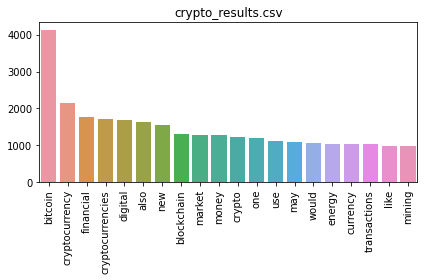

In [6]:
for key in df_dict.keys():
    if key not in ['term_abb','term_def']:
        g = sns.barplot([x[0] for x in cnt_dict[key]],[x[1] for x in cnt_dict[key]])
        g.set(title=f'{key}.csv')
        g.set_xticklabels(labels=[x[0] for x in cnt_dict[key]], rotation=90)
        plt.tight_layout()
        fig = g.get_figure()
        fig.savefig(f"./{key}.jpg") 

In [7]:
df_dict['art_results'].head()

,Unnamed: 0,sentence
0,0,Art n 1 OED Online December 2011 Oxford Univer...
1,1,There is no generally agreed definition of wha...
2,2,The nature of art and related concepts such as...
3,3,In the of the history of art artistic works h...
4,4,Over time like Plato Aristotle Socrates and K...


In [8]:
df_dict['crypto_results'].head()

,sentence,tag
0,welcome to coinmarketcap.com! this site was fo...,1
1,"here at coinmarketcap, we work very hard to en...",1
2,each of our coin data pages has a graph that s...,1
3,we receive updated cryptocurrency prices direc...,1
4,related links new to crypto? learn how to bu...,1


In [9]:
for key in df_dict.keys():
    if key not in ['term_abb','data','term_def']:
        d = df_dict[key].shape
        print(f'{key} -> {d}')

news_results -> (565, 2)
sport_results -> (3065, 2)
food_results -> (4485, 2)
art_results -> (2620, 2)
music_results -> (1689, 2)
crypto_results -> (4186, 2)


In [10]:
df_dict['crypto_results'].tag.value_counts()

1    3269
0     917
Name: tag, dtype: int64

### Preprocessing
1. Convert to lower case
2. Remove stop words
3. Remove emojis and special characters

In [11]:
for key in df_dict.keys():
    if key not in ['term_abb','term_def']:
        df_dict[key].sentence = df_dict[key].sentence.str.lower()

In [12]:
for key in df_dict.keys():
    if key not in ['term_abb','term_def']:
        df_dict[key].sentence = df_dict[key].sentence.apply(removeStopWords)

In [13]:
for key in df_dict.keys():
    if key not in ['term_abb','term_def']:
        df_dict[key].sentence = df_dict[key].sentence.apply(clean)

In [14]:
import emoji

In [15]:
for key in df_dict.keys():
    if key not in ['term_abb','term_def']:
        df_dict[key].sentence = df_dict[key].sentence.apply(emoji.replace_emoji)

### Curating the dataset
1. Take all data points from crypto_results
2. Only take 500 (or 1000) random data points from others

In [16]:
df_final = pd.DataFrame()

In [17]:
df_final = df_final.append(df_dict['crypto_results'])

In [18]:
for key in df_dict.keys():
    if key not in ['term_abb','term_def','data','crypto_results','news_results']:
        df_final = df_final.append(pd.DataFrame({'sentence':df_dict[key].sentence.sample(500).tolist(),'tag':0}),ignore_index = True)

In [19]:
df_final = df_final.append(pd.DataFrame({'sentence':df_dict['news_results'].sentence.tolist(),'tag':0}),ignore_index = True)

### Train Test split

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
train, test = train_test_split(df_final, test_size=0.1,stratify=df_final.tag,shuffle=True)

In [22]:
train.tag.value_counts()

0    3133
1    2942
Name: tag, dtype: int64

In [23]:
test.tag.value_counts()

0    349
1    327
Name: tag, dtype: int64

In [24]:
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

### Finding Max sentence length

In [25]:
all_lens = []
for i in df_final.sentence.str.split(' '):
    all_lens.append(len(i))

<AxesSubplot:ylabel='Count'>

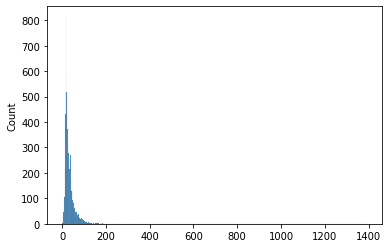

In [26]:
sns.histplot(all_lens)

In [27]:
stats.mode(np.array(all_lens))

ModeResult(mode=array([21]), count=array([290]))

### BERT model

In [28]:
from transformers import BertModel,BertTokenizer

In [29]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch.optim as optim
from transformers import AdamW,get_linear_schedule_with_warmup
from tqdm import tqdm

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [31]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [32]:
class BertBaseUnCased(nn.Module):
    def __init__(self):
        super(BertBaseUnCased,self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(0.3)
        self.linear = nn.Linear(768,1)
    def forward(self,ids,type_ids,mask):
        x = self.bert(ids,attention_mask = mask,token_type_ids = type_ids)['pooler_output']
        x = self.drop(x)
        x = self.linear(x)
        return x

In [33]:
class CryptoDataSet(Dataset):
    def __init__(self,dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,idx):
        tokens = tokenizer.encode_plus(self.dataset.sentence[idx],padding='max_length',max_length=512,truncation=True,return_tensors='pt')
        label = self.dataset.tag[idx]
        return tokens['input_ids'][0],tokens['token_type_ids'][0],tokens['attention_mask'][0],label

In [34]:
traindata = CryptoDataSet(train)
trainloader = DataLoader(traindata,batch_size=8)

In [35]:
model = BertBaseUnCased().to(device)
model.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertBaseUnCased(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [37]:
EPOCHS = 3
train_steps = int(len(train)/8 * EPOCHS)

In [38]:
optimizer = AdamW(model.parameters(),lr = 3e-5)
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=train_steps)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [39]:
criterion = nn.BCEWithLogitsLoss()

In [40]:
losses = []

In [41]:
model.to(device)

BertBaseUnCased(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [42]:
for epoch in range(EPOCHS):
    loop = tqdm(enumerate(trainloader),total = len(trainloader))
    for idx,(tokens,token_type_ids,mask,targets) in loop:
    
        tokens = tokens.to(device)
        token_type_ids = token_type_ids.to(device)
        mask = mask.to(device)
        targets = targets.to(device)
        targets = targets.reshape(-1,1)
        outputs = model(tokens,token_type_ids,mask)
        loss = criterion(outputs,targets.float())
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        loop.set_description(f"Epochs [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(loss = loss.item())

Epochs [3/3]: 100%|██████████| 760/760 [09:55<00:00,  1.28it/s, loss=0.0043] 


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

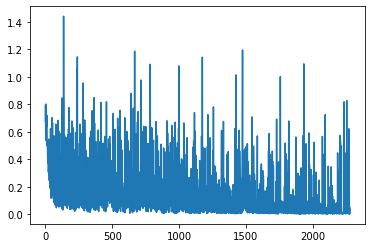

In [43]:
sns.lineplot(list(range(len(losses))),losses)

In [44]:
model.eval()

BertBaseUnCased(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [52]:
testdata = CryptoDataSet(test)
testloader = DataLoader(testdata,batch_size=16)

In [53]:
def check_accuracy():
    with torch.no_grad():
        correct = 0
        total = 0
        for tokens,token_type_ids,mask,targets in testloader:
            tokens = tokens.to(device)
            token_type_ids = token_type_ids.to(device)
            mask = mask.to(device)
            targets = targets.to(device)
            outputs = model(tokens,token_type_ids,mask).reshape(-1)
            correct = correct + torch.sum((torch.sigmoid(outputs) > 0.5).int() == targets).item()
            total = total + tokens.shape[0]
        return 100*(correct/total)

In [54]:
print(f'Accuracy -> {check_accuracy()}')

Accuracy -> 92.60355029585799


In [55]:
def make_prediction(sent):
    with torch.no_grad():
        tokens = tokenizer.encode_plus(sent,padding='max_length',max_length=512,truncation=True,return_tensors='pt')
        preds = model(tokens['input_ids'].to(device),tokens['token_type_ids'].to(device),tokens['attention_mask'].to(device))
        output = (torch.sigmoid(preds[0]) > 0.5).int().item()
        return output

In [60]:
##Checking if our model works on words like 'polygon','uniswap','web3'
make_prediction('polygon'),make_prediction('uniswap'),make_prediction('web3')

(0, 0, 0)

In [57]:
##Checking if the words 'polygon','uniswap' and 'web3' are in the csv file
for i in df_dict['crypto_results'].sentence:
    if('polygon' in i):
        print(i)
        print(' ')

polygon reports pricing nvidia s geforce gtx 1070 around 380 depending model cards sold 700 due stock shortages increase 80 percent cryptocurrency miners use stacks graphics cards solve mathematical problems need authenticate payments network create new bitcoin there s finite number bitcoins available way network designed new bitcoin takes power mine led increased demand powerful graphics cards tackle multiple cryptocurrencies
 
nvidia advising retail partners prioritize gamers miners retailers able generate impressive margins moment it s unlikely simple advice result real changes retailers limiting purchases miners can t buy stacks cards polygon reports micro center specifically offering discounts pc gamers buying cards alongside components micro center blames high demand miners constrained shipments vendors industry wide shortages
 
representative nvidia declined comment polygon citing company s quiet period nvidia s next quarterly earnings report arrives roughly two weeks
 
polygon 

In [58]:
for i in df_dict['crypto_results'].sentence:
    if('web3' in i):
        print(i)
        print(' ')

In [ ]:
for i in df_dict['crypto_results'].sentence:
    if('uniswap' in i):
        print(i)
        print(' ')

In [ ]:
data_preds = []
for i in df_dict['data'].sentence:
    data_preds.append(make_prediction(i))

In [ ]:
df_dict['data']['tag'] = data_preds

In [ ]:
data_df = pd.read_csv('../input/supermind/data.csv')

In [ ]:
data_df['tag'] = data_preds

In [ ]:
data_df.to_csv('./data_preds.csv',index=False)